# Response time minimization problem for Oslo police district

### Version 4.0

- Goal: Minimize the response time of police vehicles in Oslo police district, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

Previous notebook worked through the pipeline for the East police district, introduced problem reduction and speed-upgrades for PuLP processing.  
This notebook:
- Expands the Oslo city analysis to the entire Oslo police district which include the municipalities of Oslo, Asker and Bærum.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-02T20:10:55.777977+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

networkx  : 3.2.1
pandana   : 0.7
folium    : 0.16.0
geopandas : 0.14.3
matplotlib: 3.8.3
highspy   : 1.5.3
numpy     : 1.26.4
pyproj    : 3.6.1
pulp      : 2.8.0
shapely   : 2.0.3
osmnx     : 1.9.1
pandas    : 2.2.1



## 0. Load road network

We load a road network of Oslo police district that has been preprocessed.
- Network type: drive
- Combine Asker, Bærum and Oslo municipalities to form the Oslo police district.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node closeness centrality has already been calculated for the network and stored as a CSV file.

In [3]:
### Load road network file of Øst police district, Norway
# Read from local path
oslo_filepath = "../data/oslo/osloDriveImputed.graphml" # with travel time attribute
oslo_graph = ox.load_graphml(oslo_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
oslo_graph = ox.projection.project_graph(oslo_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of oslo_graph: {type(oslo_graph)}")
print(f"CRS of oslo_graph:  {oslo_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(oslo_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of oslo_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of oslo_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(oslo_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid          name      highway  oneway reversed  length  \
u   v      key                                                                
110 115    0    5121777  Bråtenalléen  residential   False    False 243.278   
    277510 0    5121777  Bråtenalléen  residential   False     True 151.771   

                                                         geometry  speed_kph  \
u   v      key                                                                 
110 115    0    LINESTRING (264559.267 6653336.868, 264555.742...     32.400   
    277510 0    LINESTRING (264559.267 6653336.868, 264566.273...     32.400   

                travel_time maxspeed lanes width access  ref bridge tunnel  \
u   v      key                                                               
110 115    0         27.000      NaN   NaN   NaN    NaN  NaN    NaN    NaN   
    277510 0         16.900      NaN   NaN   NaN    NaN  NaN    NaN    NaN   

               junction area est_width service  
u   v      key                                  
110 115    0        NaN  NaN       NaN     NaN  
    277510 0        NaN  NaN       NaN     NaN

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based purely on population count. Should fall in range [2000,2500]  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB - Oslo police district.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [6]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
oslo_polygon_path = "../data/oslo/osloCombinedPolygon.geojson"
population_path = "../data/oslo/osloPopulation.geojson"
oslo_polygon_gdf = gpd.read_file(oslo_polygon_path)
population_gdf = gpd.read_file(population_path)
oslo_polygon_gdf = oslo_polygon_gdf.to_crs(oslo_graph.graph['crs']) # convert to same CRS as the road network
population_gdf = population_gdf.to_crs(oslo_graph.graph['crs']) # convert to same CRS as the road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  22425006607500           7   
1  22425006607750           1   

                                            geometry  
0  POLYGON ((242500.000 6607500.000, 242500.000 6...  
1  POLYGON ((242500.000 6607750.000, 242500.000 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range of [2000,2500].

In [7]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=2500, max_range=3500)

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 7):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 2866. Target range [2500, 3500], using population multiplier: 0.00325
Nr of cells with 0 events: 3507
Nr of cells with 1 events: 1529
Nr of cells with 2 events: 259
Nr of cells with 3 events: 92
Nr of cells with 4 events: 64
Nr of cells with 5 events: 29
Nr of cells with 6 events: 20


id  population  \
2685  22637506649000        2351   
2831  22630006649250        2190   
2832  22632506649250        2014   

                                               geometry  num_points  
2685  POLYGON ((263750.000 6649000.000, 263750.000 6...           8  
2831  POLYGON ((263000.000 6649250.000, 263000.000 6...           7  
2832  POLYGON ((263250.000 6649250.000, 263250.000 6...           7

In [8]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 297 ms
Wall time: 462 ms


geometry
0  POINT (237345.650 6630513.764)
1  POINT (241872.090 6631137.939)
2  POINT (242230.816 6631062.927)

In [9]:
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=4.0e-10, simplification_tolerance=5.0, plot_results=False)

Density: Min: 6.377e-56 | Median: 4.315e-11 | Mean: 7.816e-10 | Max: 1.284e-08


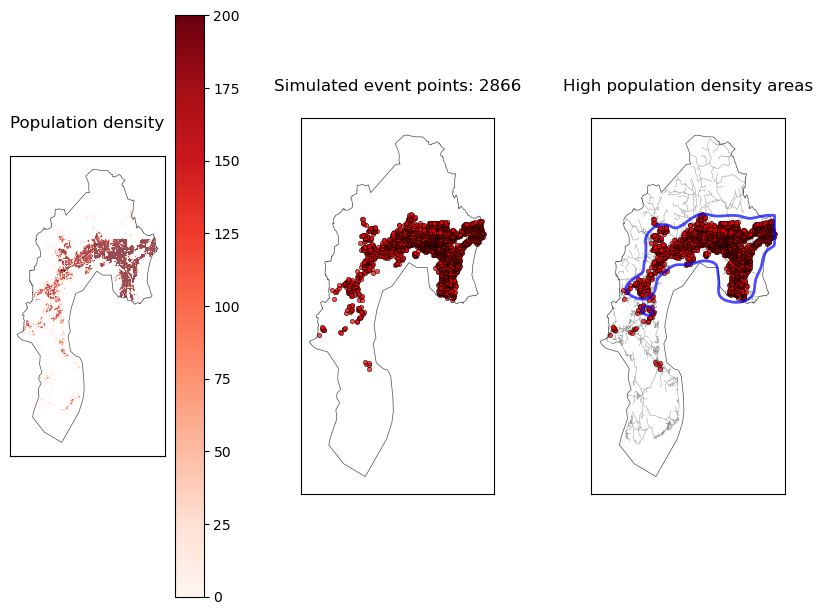

In [10]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(oslo_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measure as node attribute  
2.2 Sample candidate points and filter out poor candidate points

### 2.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [11]:
# import node closeness centrality from file
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

nodes_centrality_import = pd.read_csv("../data/oslo/osloNodeCentrality.csv")

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  ref  \
osmid                                                                   
110   6653336.868 264559.267             4 10.783 59.950     NaN  NaN   
115   6653477.248 264359.699             4 10.780 59.951     NaN  NaN   

                             geometry  closeness_centrality  \
osmid                                                         
110    POINT (264559.267 6653336.868)                 0.001   
115    POINT (264359.699 6653477.248)                 0.001   

       betweenness_centrality  
osmid                          
110                529576.000  
115                667728.667

Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

### 2.2 Sample candidate points and filter out poor candidate points

#### Steps:
1. Sample a set of random points from the road network (using the high population density areas as a polygon).
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [21]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 17638, nr of police car nodes: 100


y          x  street_count    lon    lat highway  ref  \
osmid                                                                       
25313778  6651402.277 266888.492             3 10.827 59.934     NaN  NaN   
938243881 6647458.698 248317.175             3 10.501 59.888     NaN  NaN   

                                 geometry  closeness_centrality  \
osmid                                                             
25313778   POINT (266888.492 6651402.277)                 0.001   
938243881  POINT (248317.175 6647458.698)                 0.001   

           betweenness_centrality  
osmid                              
25313778               790280.500  
938243881             4151209.500

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


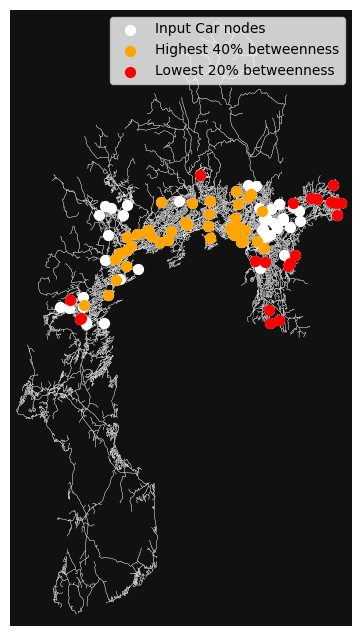

In [22]:
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, top_percent=0.4, bottom_percent=0.20, 
                                                            input_graph=oslo_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 64, after discarding the 16 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


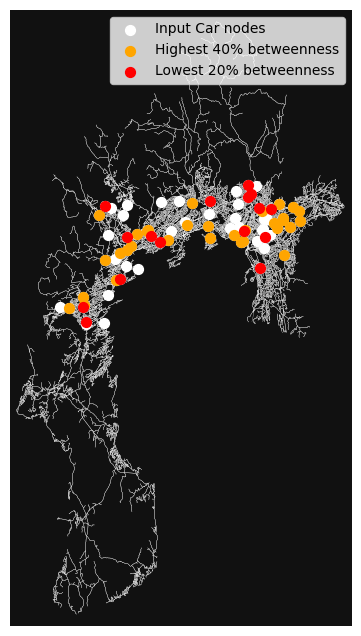

In [23]:
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, top_percent=0.4, bottom_percent=0.20, 
                                                            input_graph=oslo_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 64
Remaining nr of car nodes: 30, after removing the 34 nodes that are within 1500 m of each other



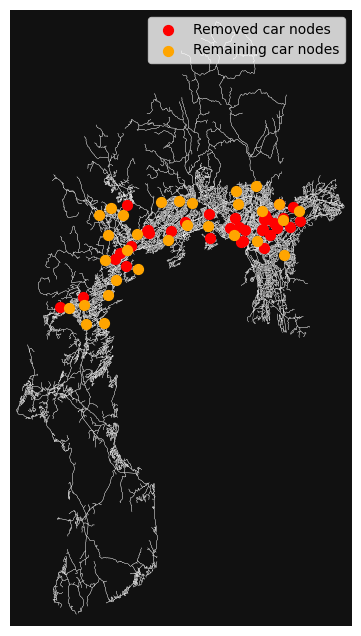

In [31]:
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, min_distance=1500, 
                                input_graph=oslo_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [32]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
oslo_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of oslo_network_pdna: {type(oslo_network_pdna)}")
print(f"Network nodes:")
oslo_network_pdna.nodes_df.head(2)

type of oslo_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                       
110   264559.267 6653336.868
115   264359.699 6653477.248

In [33]:
print(f"Network edges: ")
oslo_network_pdna.edges_df.head(2)

Network edges: 


from      to  length  travel_time
0   110     115 243.278       27.000
1   110  277510 151.771       16.900

In [34]:
# %%time
# oslo_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network. Therefore, we need to snap the event points to the Pandana network.

In [35]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = oslo_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y
0  POINT (237345.650 6630513.764)    3498727771 237298.354 6630594.204
1  POINT (241872.090 6631137.939)     387498173 241842.967 6631150.991

In [36]:
# Get list of nearest node ids for event locations
event_nodes_pdna = oslo_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = oslo_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([1441725564,   25648861, 1124990406,   41174804,  116002092],
      dtype=int64)

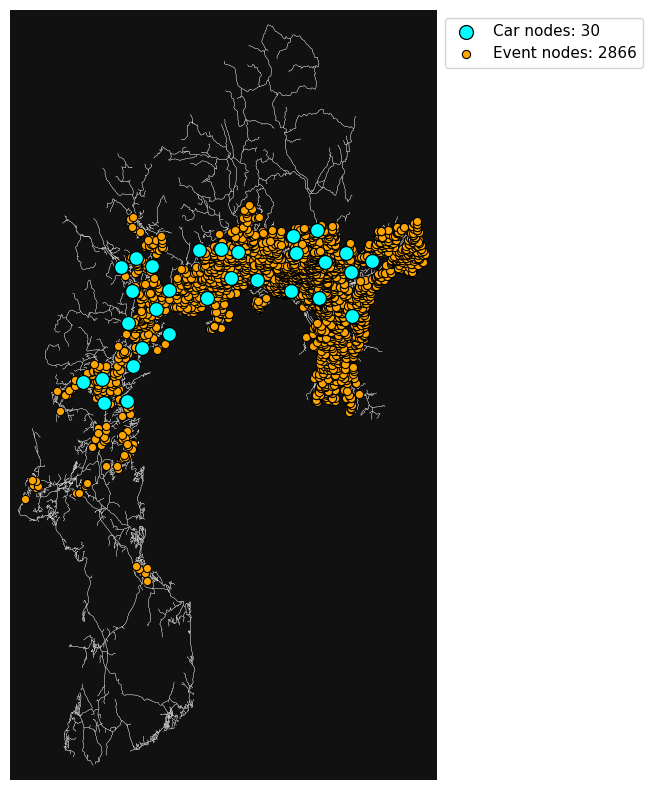

In [37]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(oslo_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [38]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [39]:
%%time
# distance between each possible pair of facilities-clients combination
distances = oslo_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = oslo_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(travel_times))
print("Number of travel_times calculated: ", len(travel_times))
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

<class 'list'>
Number of travel_times calculated:  85980
5 first origin-destination distances [m]     : [34893.069, 30672.191, 30562.761, 33492.569, 32824.821]
5 first origin-destination travel times [sec]: [1865.399, 1684.799, 1672.599, 1900.999, 1826.699]
CPU times: total: 6.67 s
Wall time: 672 ms


In [49]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   85980.000
mean      903.064
std       442.747
min         0.000
25%       534.800
50%       877.700
75%      1234.825
max      3003.998
dtype: float64


In [50]:
# Restructure the distances and travel times arrays into a DataFrame (Coslo Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix.head(2)

distance  travel_time   carNodeID  eventNodeID
0 34893.069     1865.399  1441725564   3498727771
1 30672.191     1684.799  1441725564    387498173

In [51]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 34893.069     1865.399  1441725564   3498727771 237298.354 6630594.204
1 30672.191     1684.799  1441725564    387498173 241842.967 6631150.991

In [52]:
# Save coslo matrix to CSV
CostMatrix.to_csv("../data/oslo/osloCostMatrix.csv", index=False)

# # import coslo matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/oslo/osloCostMatrix.csv")
# CostMatrix_imported.head(2)

CostMatrix.drop(columns="distance", inplace=True)

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [142]:
%%time
# find the total number of unique events from the reduced coslo matrix
nr_of_unique_events = CostMatrix['eventNodeID'].nunique()
print(f"Total number of unique events: {nr_of_unique_events}")

# Preprocess the coslo matrix
# 1) Convert to a dictionary for fast lookup
# 2) Reduce problem size: Remove top x% travel times, as there is probably a closer car to the event
DISCARD_THRESHOLD = 0.10
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Total number of unique events: 2420
Filtering out 10% highest travel times - keeping only travel times <= 1487 sec, or 24.8 min
Original nr of pairs: 72600 | Filtered nr of pairs: 65343
Original max travel time: 3003.998 | Filtered max travel time: 1486.799
Original min travel time: 0.0 | Filtered min travel time: 0.0
CPU times: total: 188 ms
Wall time: 444 ms


### 5.2 Setup LP problem

In [143]:
# Constants
NR_OF_CARS = 4
CAR_CAPACITY = 800

# # Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 30
Number of events: 2420
Number of decision variables: 65373
Number of constraints: 67794
Number of non-zero coefficients: 65373
Number of non-zero coefficients in the objective function: 65342
PuLP Problem setup took 2.64 seconds


### 5.5 Run the solvers

- **PULP_CBC (COIN-OR Branch and Cut)** - open-source solver that is included in the PuLP package.
- **HiGHS (High-Performance Solver)** - a high-performance solver that use the HiGHS optimization engine.

1st run of each solver will relax the integer variable constraint (`mip=False`) for fast computation. 2nd run of each solver will use proper integer constraints (`mip=True`) to get the slow, final solution for verification.

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [144]:
# Inspect available pulp solvers
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

PULP_CBC_CMD with LP relaxation found 3/4 locations in 29.34 seconds.
Switching to MILP solver configuration to find optimal solution.



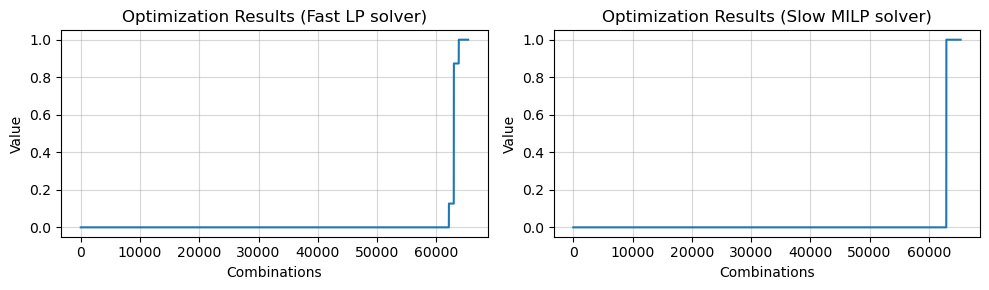

Optimal police car locations found: 4/4 in 351.61 seconds: [1441725564 1124990406 5626106403 6985135237]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 843736.5300 seconds, or 14062.28 minutes, or 234.37 hours
(Note: Currently reducing the Cost matrix by 10%)


In [145]:
# Run the solver
solve = utilityModule.run_solvers(problem, P, nr_of_locations=4, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=True)
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")

### 5.6 Extract results for inspection

In [146]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)

Optimal police car locations: dict_keys([1441725564, 1124990406, 5626106403, 6985135237])
Car 1441725564 is assigned 800/800 events
Car 1124990406 is assigned 800/800 events
Car 5626106403 is assigned 618/800 events
Car 6985135237 is assigned 202/800 events
Summing the events for each car gives 2420 events, which should equal the total number of unique events: 2420


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 30 | Optimal locations in solution: 4
- Events: 2420 | Max event capacity per police car: 800

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 843737 sec | 14062.3 min | 234.37 hours

Police car id: 1441725564 handles 800 events | Capacity: 100.00% | Total response time: 5029.13 min | Avg response time: 6.29 min
Police car id: 1124990406 handles 800 events | Capacity: 100.00% | Total response time: 3247.56 min | Avg response time: 4.06 min
Police car id: 5626106403 handles 618 events | Capacity: 77.25% | Total response time: 3987.26 min | Avg response time: 6.45 min
Police car id: 6985135237 handles 202 events | Capacity: 25.25% | Total response time: 1798.33 min | Avg response time: 8.90 min


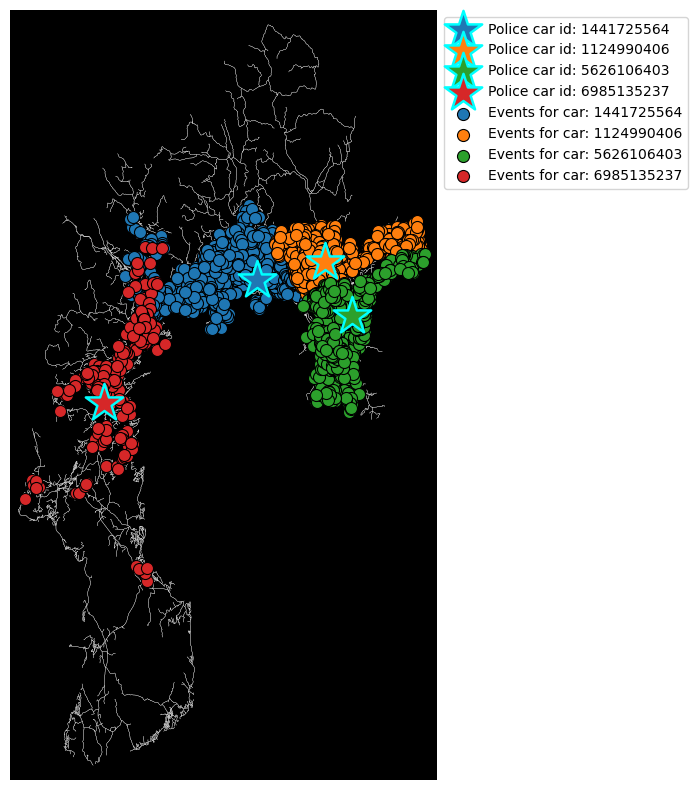

CPU times: total: 1.81 s
Wall time: 2.7 s


In [147]:
%%time
utilityModule.plot_optimal_allocations(oslo_graph, optimal_locations_gdf, car_to_events_df, 
                        car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem)

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [160]:
# Define how many trip times to visualize
TRIP_TIMES = [8, 20, 40]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

Isochrone polygons for the travel times: [8, 20, 40] minutes


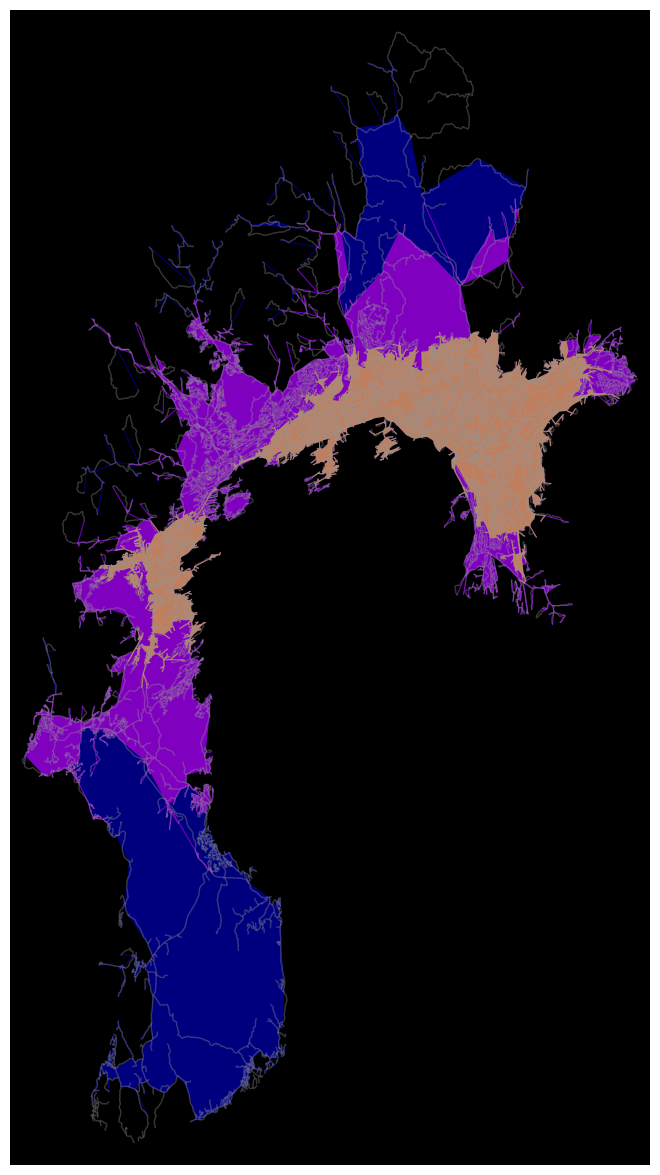

CPU times: total: 1min 41s
Wall time: 2min 30s


In [161]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(oslo_graph, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=30, node_buff=0, infill=True)

# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(oslo_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(oslo_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
# iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.5, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.5, zorder=-1)
        ax.add_patch(patch)

print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

In [162]:
%%time
# Plot leaflet map
graph_map = utilityModule.plot_leaflet_map(oslo_graph, TRIP_TIMES, merged_isochrones, oslo_polygon_gdf, background_poly=True)
graph_map

CPU times: total: 781 ms
Wall time: 1.08 s
